In [1]:
import numpy

large_field = numpy.load("/rds/project/bn204/rds-bn204-asterics/jck42/BiSpectrum/Binned_Data_LargeField/EQ14/XX/fornaxA.npz")
cl_lf = large_field['closures']

In [2]:
%load_ext cython

In [3]:
%run procps.py
%run plotprelude.py

In [4]:
%%cython -a
import numpy

def cmedn_c(a, axis, n):
    """Circular MEDian N

    Returns n values around the median computed along axis using
    circular stats. NB values are not necessarily sorted in distance
    from median (argpartition is used)
    """
    p=a[numpy.newaxis, :]-a[:, numpy.newaxis]
    p=(p+numpy.pi) % (2 * numpy.pi) - numpy.pi
    p = numpy.abs(p).sum(1)
    ii=numpy.argpartition(p, n+1, axis=axis)
    return numpy.choose(ii[0:n], a)

def mdays_c(dc, n):
    """Median across Days

    Compute cmedn across the days axis. Needed because cmedn is N^2
    memory scaling
    """
    dnew=numpy.array([[cmedn_c(dc[i,:,j], axis=0, n=n) for j in range(dc.shape[2])] for i in range(dc.shape[0])])
    # Rotate axes so days are in position 1 again
    return numpy.moveaxis(dnew, 2, 1)

In [5]:
%%cython -a
import numpy

def triad_flagging(closures, threshold=100, reduc_threshold=1.0):
        """
        Takes closures and runs a circular sigma clip across them. 
        If a particular triad is not behaving at a particular record/day
        in > chan_threshold channels, then put a 1 in a flag array.

        Inputs:

        closures       [Numpy Array] Binned closures of shape 
                       [lst, day, trid, channel]
        chan_threshold [Integer] Number of channels that a triad 
                       is off in before a flag gets set.
        sigma          [Float] Sigma value  to exceed before a triad
                       is considered errant.

        Returns:

        fl             [Numpy Array][Bool] Flag array.

        """
        cls = closures.shape[:3]
        fl = numpy.zeros(shape=cls)

        for t in numpy.arange(closures.shape[0]):
            for d in numpy.arange(closures.shape[1]):
                for c in numpy.arange(closures.shape[3]):
                    tr = closures[t,d,:,c]
                    
                    tr_x = numpy.cos(tr)
                    tr_y = numpy.sin(tr)
                    averaged_x = numpy.mean(tr_x)
                    averaged_y = numpy.mean(tr_y)
                    
                    r = numpy.sqrt(numpy.square(averaged_x) + numpy.square(averaged_y))
                    av_ang = numpy.arctan2(averaged_y,averaged_x)
                    sigma = numpy.sqrt(-2 * numpy.log(r))

                    for triad in numpy.arange(closures.shape[2]):
                        if numpy.abs(closures[t,d,triad,c] - av_ang) > sigma:
                            fl[t,d,triad] += 1
        return fl
    
    

def triad_flagging_ctest(closures, threshold=100, reduc_threshold=1.0):
        """
        Takes closures and runs circular discordance C test across them. 
        If a particular triad is not behaving at a particular record/day
        in > chan_threshold channels, then put a 1 in a flag array.

        Inputs:

        closures       [Numpy Array] Binned closures of shape 
                       [lst, day, trid, channel]
        chan_threshold [Integer] Number of channels that a triad 
                       is off in before a flag gets set.
        sigma          [Float] Sigma value  to exceed before a triad
                       is considered errant.

        Returns:

        fl             [Numpy Array][Bool] Flag array.

        """
        cls = closures.shape[:3]
        fl = numpy.zeros(shape=cls)

        for t in numpy.arange(closures.shape[0]):
            for d in numpy.arange(closures.shape[1]):
                for c in numpy.arange(closures.shape[3]):
                    tr = numpy.ma.masked_array(closures[t,d,:,c])
                    tr_x = numpy.cos(tr)
                    tr_y = numpy.sin(tr)
                    averaged_x = numpy.mean(tr_x)
                    averaged_y = numpy.mean(tr_y)
                    
                    r = numpy.sqrt(numpy.square(averaged_x) + numpy.square(averaged_y))
                    #av_ang = numpy.arctan2(averaged_y,averaged_x)
                    #sigma = numpy.sqrt(-2 * numpy.log(r))

                    for triad in numpy.arange(closures.shape[2]):
                        tr[triad] = numpy.ma.masked
                        trav_x = numpy.cos(tr)
                        trav_y = numpy.sin(tr)
                        mta_x = numpy.mean(trav_x)
                        mta_y = numpy.mean(trav_y)
                        rbar = numpy.sqrt(numpy.square(mta_x) + numpy.square(mta_y))
#                        print(rbar.shape)
#                        print(r.shape)
#                        print(reduc_threshold)
                        if (r - rbar)/r > reduc_threshold:
                            fl[t,d,triad] += 1
                        
                        tr[triad] = closures[t,d,triad,c]
                        
                        
                        
        return fl


In [6]:
#Medians for Equilateral 14m triads
pp_lf_1=mdays_c(cl_lf[:,0:22], 1)
pp_lf_2=mdays_c(cl_lf[:,22:], 1)

pp_gc=numpy.concatenate((pp_lf_1, pp_lf_2), axis=1)

(-3.141592653589793, 3.141592653589793)

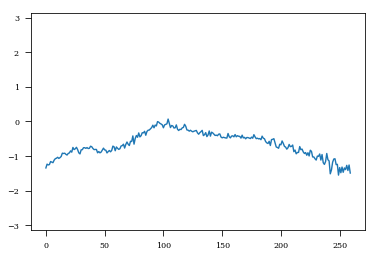

In [17]:
import matplotlib.pyplot as plt
xvar = numpy.arange(260)

plt.plot(xvar,pp_gc[89,0,19,120:380])
plt.ylim(-numpy.pi,numpy.pi)

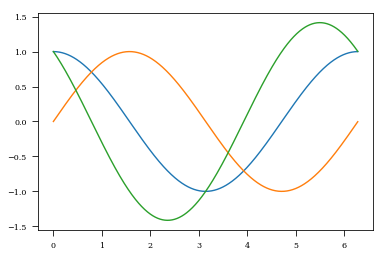

In [8]:
x = numpy.arange(0,2*numpy.pi,0.01)
plt.plot(x,numpy.cos(x))
plt.plot(x,numpy.sin(x))
plt.plot(x,numpy.cos(x)+numpy.sin(-x))

In [9]:
sigclip = triad_flagging_ctest(cl_lf[30:130,0:10,:,120:380],reduc_threshold=0.2)

In [10]:
sigs = numpy.sum(sigclip,axis=1)
sigs = numpy.sum(sigs,axis=0)

In [11]:
print(sigs)
print(numpy.argwhere(sigs>=5))

[269. 216. 266. 234. 269. 252. 212. 258. 249. 297. 276. 262. 249. 233.
 260. 264. 271. 263. 277. 246. 205. 182. 228. 237. 237. 281. 236. 271.
 244. 240. 225. 214. 204. 208. 207. 265. 246. 250. 244. 229. 278. 224.
 215. 232. 232. 239. 215. 220.]
[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]
 [19]
 [20]
 [21]
 [22]
 [23]
 [24]
 [25]
 [26]
 [27]
 [28]
 [29]
 [30]
 [31]
 [32]
 [33]
 [34]
 [35]
 [36]
 [37]
 [38]
 [39]
 [40]
 [41]
 [42]
 [43]
 [44]
 [45]
 [46]
 [47]]


In [46]:
triads=large_field['triads']

In [47]:
print(triads[10])
print(triads[14])
print(triads[18])
print(triads[23])
print(triads[25])


[13 14 26]
[24 37 38]
[26 39 40]
[37 38 52]
[38 39 53]
